# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-m`
  - Task 5: Evaluating our Retriever

- 🤝 Breakout Room #2:
  - Task 1: Vibe Checking Our LCEL RAG Chain
  - Task 2: Ragas Evaluation



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

##### ❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

---

**ANSWER:**

We are specifically relating *the questions* to *the documents*. This means that we are making our embedding model at the very specific task of relating potential questions to specific documents.

There are many caveats, but the main ones are:

- Your Q's should reflect the Q's of your users
- This kind of fine-tuning will (purposefully) "overfit" on your data; this is the desired result in this case.

## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### 🚀 Set cache for LnagChain to reduce cost

In [1]:
# # 🚀 My own cell
# import os
# from langchain.globals import set_llm_cache
# from langchain_community.cache import SQLiteCache
# if not os.path.exists("langchain_cache"): os.mkdir("langchain_cache")
# set_llm_cache(SQLiteCache(database_path="langchain_cache/sqlite_cache.db"))

### Nest Asyncio

In [2]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

In [3]:
# !pip install -qU langchain_openai langchain_huggingface langchain_core langchain langchain_community langchain-text-splitters

In [4]:
# !pip install -qU faiss-cpu unstructured==0.15.7 python-pptx==1.0.2 nltk==3.9.1

### Provide OpenAI API Key

In [5]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

# 🚀 For LangSmith tracing
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter Your LangChain API Key: ")
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGSMITH_PROJECT"] = 'AIE4-WEEK5-DAY1'


## Task 2: Loading Data

We'll be using a recent document released by the EU 'laying down harmonised rules on artificial intelligence and amending Regulations'.

The data can be found [here](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A32024R1689), though we will be using a HTML version which was collected into the AIM DataRepository.

First, we'll clone and then `cd` into the DataRepository.

In [6]:
# !git clone https://github.com/AI-Maker-Space/DataRepository.git

In [7]:
# %cd DataRepository

Next we're going to be using the `UnstructuredHTMLLoader` to load our HTML document into a LangChain document using the [Unstructured](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.html.UnstructuredHTMLLoader.html) library.

In [8]:
from langchain_community.document_loaders import UnstructuredHTMLLoader

training_documents_loaded = UnstructuredHTMLLoader("eu_ai_act.html")

In [9]:
# 🚀 My own cell

documents = training_documents_loaded.load()

print(len(documents))
print(documents[0].metadata)
print(documents[0].page_content[:1000])

1
{'source': 'eu_ai_act.html'}
Official Journal of the European Union EN L series

2024/1689 12.7.2024

REGULATION (EU) 2024/1689 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL

of 13 June 2024

laying down harmonised rules on artificial intelligence and amending Regulations (EC) No 300/2008, (EU) No 167/2013, (EU) No 168/2013, (EU) 2018/858, (EU) 2018/1139 and (EU) 2019/2144 and Directives 2014/90/EU, (EU) 2016/797 and (EU) 2020/1828 (Artificial Intelligence Act)

(Text with EEA relevance)

THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION,

Having regard to the Treaty on the Functioning of the European Union, and in particular Articles 16 and 114 thereof,

Having regard to the proposal from the European Commission,

After transmission of the draft legislative act to the national parliaments,

Having regard to the opinion of the European Economic and Social Committee (1),

Having regard to the opinion of the European Central Bank (2),

Having regard to the opinion of the Co

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

In [11]:
training_documents = text_splitter.split_documents(training_documents_loaded.load())

In [12]:
len(training_documents)

1029

Next, we're going to associate each of our chunks with a unique identifier.

In [13]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    print("the same id!!")
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

print(len(id_set))

# 🚀 My opinion
# Is the above 'while' clause necessary? I think it's not necessary because the uuid is unique. 

1029


Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [14]:
# training_split_documents = training_documents[:300]
# val_split_documents = training_documents[300:350]
# test_split_documents = training_documents[350:400]

# 🚀 Save tham as pickle for reproducibility (random id)

# import pickle
# with open('generated_data/training_split_documents.pkl', 'wb') as f:
#     pickle.dump(training_split_documents, f)
# with open('generated_data/val_split_documents.pkl', 'wb') as f:
#     pickle.dump(val_split_documents, f)
# with open('generated_data/test_split_documents.pkl', 'wb') as f:
#     pickle.dump(test_split_documents, f)

In [15]:
# 🚀 Load pickle files

import pickle
with open('generated_data/training_split_documents.pkl', 'rb') as f:
    training_split_documents = pickle.load(f)
with open('generated_data/val_split_documents.pkl', 'rb') as f:
    val_split_documents = pickle.load(f)
with open('generated_data/test_split_documents.pkl', 'rb') as f:
    test_split_documents = pickle.load(f)

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4o-mini` (released [July 18th](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)).

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [16]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [17]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

In [18]:
# 🚀 I modified the above code for ease of use later. (To result a list of outputs)
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

["QUESTION #1", "QUESTION #2", ...]
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate([('human', qa_prompt)])

We'll create a simple chain to query the LLM!

In [19]:
from langchain_core.runnables import RunnableLambda
import json

question_generation_chain = (
    qa_prompt_template | 
    qa_chat_model | 
    RunnableLambda(lambda x: json.loads(x.content))
)  # 🚀 I added an output parser.

In [20]:
# 🚀 My own cell
# 🚀 Let's try it out

input = {
    'n_questions': 2,
    'context': training_documents[0].page_content
}

output = question_generation_chain.invoke(input)
output

['What is the purpose of Regulation (EU) 2024/1689?',
 'Which regulations and directives are amended by the Artificial Intelligence Act?']

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [21]:
# 🚀 I wrote the code in a way that utilizes LangChain's LCEL as fully as possible.

import uuid
from langchain_core.documents import Document
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

# 🚀 helper function: creating question ids
def get_question_id(n_questions: int):
    return [str(uuid.uuid4()) for _ in range(n_questions)]

# 🚀 helper function: connecting questions to contexts by question ids.
def get_questions_and_relevant_docs(state: dict):
    questions = { id:question for id, question in zip(state['question_id'], state['questions']) }
    relevant_docs = { id:[state['context_id']] for id in state['question_id'] }
    return questions, relevant_docs

# 🚀 question_generation_pipeline -> input: {'n_questions':int , 'document':list[Document]} 
question_generation_pipeline = (
    RunnablePassthrough.assign(
        question_id = lambda x : get_question_id(x['n_questions']), # list[str]
        context = lambda x : x['document'].page_content,  # str
        context_id = lambda x : x['document'].metadata['id']   # str
        ) | 
    RunnablePassthrough.assign(
        questions = question_generation_chain
        ) | # list[str]
    RunnableLambda(lambda x: get_questions_and_relevant_docs(x)) # (dict, dict)
).with_config({'run_name': 'QnD-Generation'}) 



# 🚀 helper function: adaptor for batch input
def adapt_batch_input(input: dict)-> list[dict]:
    documents = input['documents']
    n_questions = input['n_questions']
    return [ {'document': document, 'n_questions':n_questions} for document in documents] 


# 🚀 helper function: parsing batched output
def parseing_batched_outputs(outputs: list[tuple[dict, dict]]):
    questions = {}
    relevant_docs = {}
    for output in outputs:
        questions.update(output[0])
        relevant_docs.update(output[1])
    return questions, relevant_docs


# 🚀 Batch processing using .map() method
question_generation_pipeline_in_batch = (
  RunnableLambda(adapt_batch_input) |  
  question_generation_pipeline.map() |
  RunnableLambda(parseing_batched_outputs)   
).with_config({'run_name': 'QnD-Generation_in_batch'}) 

We'll use the function to generate training, validation, and test data with `n_questions=2` for each.

In [22]:
# training_questions, training_relevant_contexts = question_generation_pipeline_in_batch.invoke({'documents': training_split_documents, 'n_questions':2})

In [23]:
# val_questions, val_relevant_contexts = question_generation_pipeline_in_batch.invoke({'documents': val_split_documents, 'n_questions':2})

In [24]:
# test_questions, test_relevant_contexts = question_generation_pipeline_in_batch.invoke({'documents': test_split_documents, 'n_questions':2})

In [25]:
# 🚀 Save the results using pickle!!
# import pickle

# with open('generated_data/training_questions.pkl', 'wb') as f:
#     pickle.dump(training_questions, f)
# with open('generated_data/training_relevant_contexts.pkl', 'wb') as f:
#     pickle.dump(training_relevant_contexts, f)

# with open('generated_data/val_questions.pkl', 'wb') as f:
#     pickle.dump(val_questions, f)
# with open('generated_data/val_relevant_contexts.pkl', 'wb') as f:
#     pickle.dump(val_relevant_contexts, f)

# with open('generated_data/test_questions.pkl', 'wb') as f:
#     pickle.dump(test_questions, f)
# with open('generated_data/test_relevant_contexts.pkl', 'wb') as f:
#     pickle.dump(test_relevant_contexts, f)

In [26]:
# 🚀 Load the results using pickle!!
import pickle
with open('generated_data/training_questions.pkl', 'rb') as f:
    training_questions = pickle.load(f)
with open('generated_data/training_relevant_contexts.pkl', 'rb') as f:
    training_relevant_contexts = pickle.load(f)

with open('generated_data/val_questions.pkl', 'rb') as f:
    val_questions = pickle.load(f)
with open('generated_data/val_relevant_contexts.pkl', 'rb') as f:
    val_relevant_contexts = pickle.load(f)
    
with open('generated_data/test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)
with open('generated_data/test_relevant_contexts.pkl', 'rb') as f:
    test_relevant_contexts = pickle.load(f)

In [27]:
# 🚀 Inspection time!!

def get_context(question_id: str, question_doc_map: list[dict], src_document: list[Document]):
    context = next(x for x in src_document if x.metadata['id'] == question_doc_map[question_id][0]).page_content
    return context

for training_question_id in training_questions:
    print(f"question id: {training_question_id}")
    print("_"*50)
    print(f"question: {training_questions[training_question_id]}")
    print("_"*50)
    print(f"context: {get_context(training_question_id, training_relevant_contexts, training_split_documents)}")

    break




question id: bd6da5f0-d967-4a61-9294-166068d9ce2d
__________________________________________________
question: What is the purpose of Regulation (EU) 2024/1689?
__________________________________________________
context: Official Journal of the European Union EN L series

2024/1689 12.7.2024

REGULATION (EU) 2024/1689 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL

of 13 June 2024

laying down harmonised rules on artificial intelligence and amending Regulations (EC) No 300/2008, (EU) No 167/2013, (EU) No 168/2013, (EU) 2018/858, (EU) 2018/1139 and (EU) 2019/2144 and Directives 2014/90/EU, (EU) 2016/797 and (EU) 2020/1828 (Artificial Intelligence Act)

(Text with EEA relevance)

THE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION,

Having regard to the Treaty on the Functioning of the European Union, and in particular Articles 16 and 114 thereof,

Having regard to the proposal from the European Commission,


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

> NOTE: If you ran into issues creating the data - you can use the data from the DataRespository. It's simply called: `train_dataset.jsonl`, etc.

In [28]:
import json

# training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

# train_dataset = {
#     "questions" : training_questions,
#     "relevant_contexts" : training_relevant_contexts,
#     "corpus" : training_corpus
# }

# with open("training_dataset.jsonl", "w") as f:
#   json.dump(train_dataset, f)

# 🚀 Load jsonl data
with open("training_dataset.jsonl", "r") as f:
  train_dataset = json.load(f)

In [29]:
# val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

# val_dataset = {
#     "questions" : val_questions,
#     "relevant_contexts" : val_relevant_contexts,
#     "corpus" : val_corpus
# }

# with open("val_dataset.jsonl", "w") as f:
#   json.dump(val_dataset, f)

# 🚀 Load jsonl data
with open("val_dataset.jsonl", "r") as f:
  val_dataset = json.load(f)

In [30]:
# train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

# test_dataset = {
#     "questions" : test_questions,
#     "relevant_contexts" : test_relevant_contexts,
#     "corpus" : train_corpus
# }

# with open("test_dataset.jsonl", "w") as f:
#   json.dump(test_dataset, f)

# 🚀 Load jsonl data
with open("test_dataset.jsonl", "r") as f:
  test_dataset = json.load(f)

## Task 4: Fine-tuning `snowflake-arctic-embed-m`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-m`](https://huggingface.co/Snowflake/snowflake-arctic-embed-m) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

In [31]:
# !pip install -qU sentence_transformers datasets pyarrow

In [32]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-m"
model = SentenceTransformer(model_id)
model

/home/jetlee/anaconda3/envs/AIE4/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [33]:
# 🚀 my own cell
# 🚀 I am not familiar with sentence transformers. So I look into it with the help of ChatGPT.

''' 
SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
'''

#  Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel
# - Base model: BertModel
# - max_seq_length: 512. If the input text is longer than 512 tokens, it will be truncated.
# - do_lower_case: 512. The original casing of the input text is preserved. Not forced to put in lower case.

#  Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
# - word_embedding_dimension: 768. The dimension of the word embeddings.
# - pooling_mode_cls_token: True. The CLS token is used as the sentence embedding. No aggregation of other embeddings is done.

#  Normalize()
# - This layer normalizes the resulting sentence embeddings to have unit length (L2 norm = 1)

" \nSentenceTransformer(\n  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel \n  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})\n  (2): Normalize()\n)\n"

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [34]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

In [35]:
# 🚀 my own cell
# 🚀 "from torch.utils.data import DataLoader" -> Efficiently load data in batches and provide them to a model during training or evaluation.
# - Batching: It automatically divides the dataset into batches of a specified size. 
# - Shuffling: It can shuffle the data at each epoch
# - Parallelism:  It allows for loading data using multiple subprocesses (with the num_workers parameter).
# - Custom Collation: You can define how a batch of data should be collated together by passing a custom collate_fn.

from torch.utils.data import DataLoader

# Assuming you have a dataset
dataset = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=3, shuffle=True)

# Iterate over the DataLoader
for batch in data_loader:
    print(batch)


tensor([1, 7, 8])
tensor([4, 2, 6])
tensor([5, 9, 3])


In [36]:
# 🚀 my own cell
# 🚀 "from torch.utils.data import Dataset" -> Abstract class provided by PyTorch that you can subclass to create your own dataset. It represents a dataset that can be loaded by DataLoader.

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the sample at index idx
        sample = self.data[idx]
        return sample

# Create an instance of CustomDataset
dataset = CustomDataset([1, 2, 3, 4, 5])


In [37]:
# 🚀 my own cell
# 🚀 "from sentence_transformers import InputExample" -> Represent a single input example (such as a sentence pair) for training or evaluation purposes of sentence transformer models.

# - text: list[str]. A list of texts (usually 1 or 2 sentences) that represent the input data.
# - label: A numerical label associated with the input example. This is often used in supervised learning to indicate similarity scores, classes, or relevance between text pairs.


We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [38]:
BATCH_SIZE = 20

Let's move our dataset into the expected format for training.

In [39]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

In [40]:
# 🚀 my own cell
print(len(examples))
print(examples[0].texts)
print(examples[0].label)

600
['What is the purpose of Regulation (EU) 2024/1689?', 'Official Journal of the European Union EN L series\n\n2024/1689 12.7.2024\n\nREGULATION (EU) 2024/1689 OF THE EUROPEAN PARLIAMENT AND OF THE COUNCIL\n\nof 13 June 2024\n\nlaying down harmonised rules on artificial intelligence and amending Regulations (EC) No 300/2008, (EU) No 167/2013, (EU) No 168/2013, (EU) 2018/858, (EU) 2018/1139 and (EU) 2019/2144 and Directives 2014/90/EU, (EU) 2016/797 and (EU) 2020/1828 (Artificial Intelligence Act)\n\n(Text with EEA relevance)\n\nTHE EUROPEAN PARLIAMENT AND THE COUNCIL OF THE EUROPEAN UNION,\n\nHaving regard to the Treaty on the Functioning of the European Union, and in particular Articles 16 and 114 thereof,\n\nHaving regard to the proposal from the European Commission,']
0


Now we can create a `torch` `DataLoader`!

In [41]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

print(f"Number of batches: {len(loader)}")

Number of batches: 30


Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [42]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64] # 🚀 since embedding dimension of "Snowflake/snowflake-arctic-embed-m" is 768
inner_train_loss = MultipleNegativesRankingLoss(model)  # 🚀 loss object for embedding models typically requires model itself when instantiating
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

### 🚀 Activity #2-1: MultipleNegativesRankingLoss (thanks to ChatGPT)

- Data set : A set of sentence pairs where each pair consists of an "anchor" and a "positive":
    - Anchor: "What is the capital of France?" Positive: "Paris is the capital of France."
    - Anchor: "Who wrote '1984'?" Positive: "'1984' was written by George Orwell."

    
    
- Trick : In addition to a potive in association with a given anchor, we add multiple negatives. The idea is that we make our embedding model learn that the positive is more similar to the anchor than the negatives.



- How does it work? : 
    - Step 1) Negative Sampling in Each Batch
    - Step 2) Similarity Calculation
    - Step 3) Cross-Entropy Loss
    - Step 4) Backpropagation

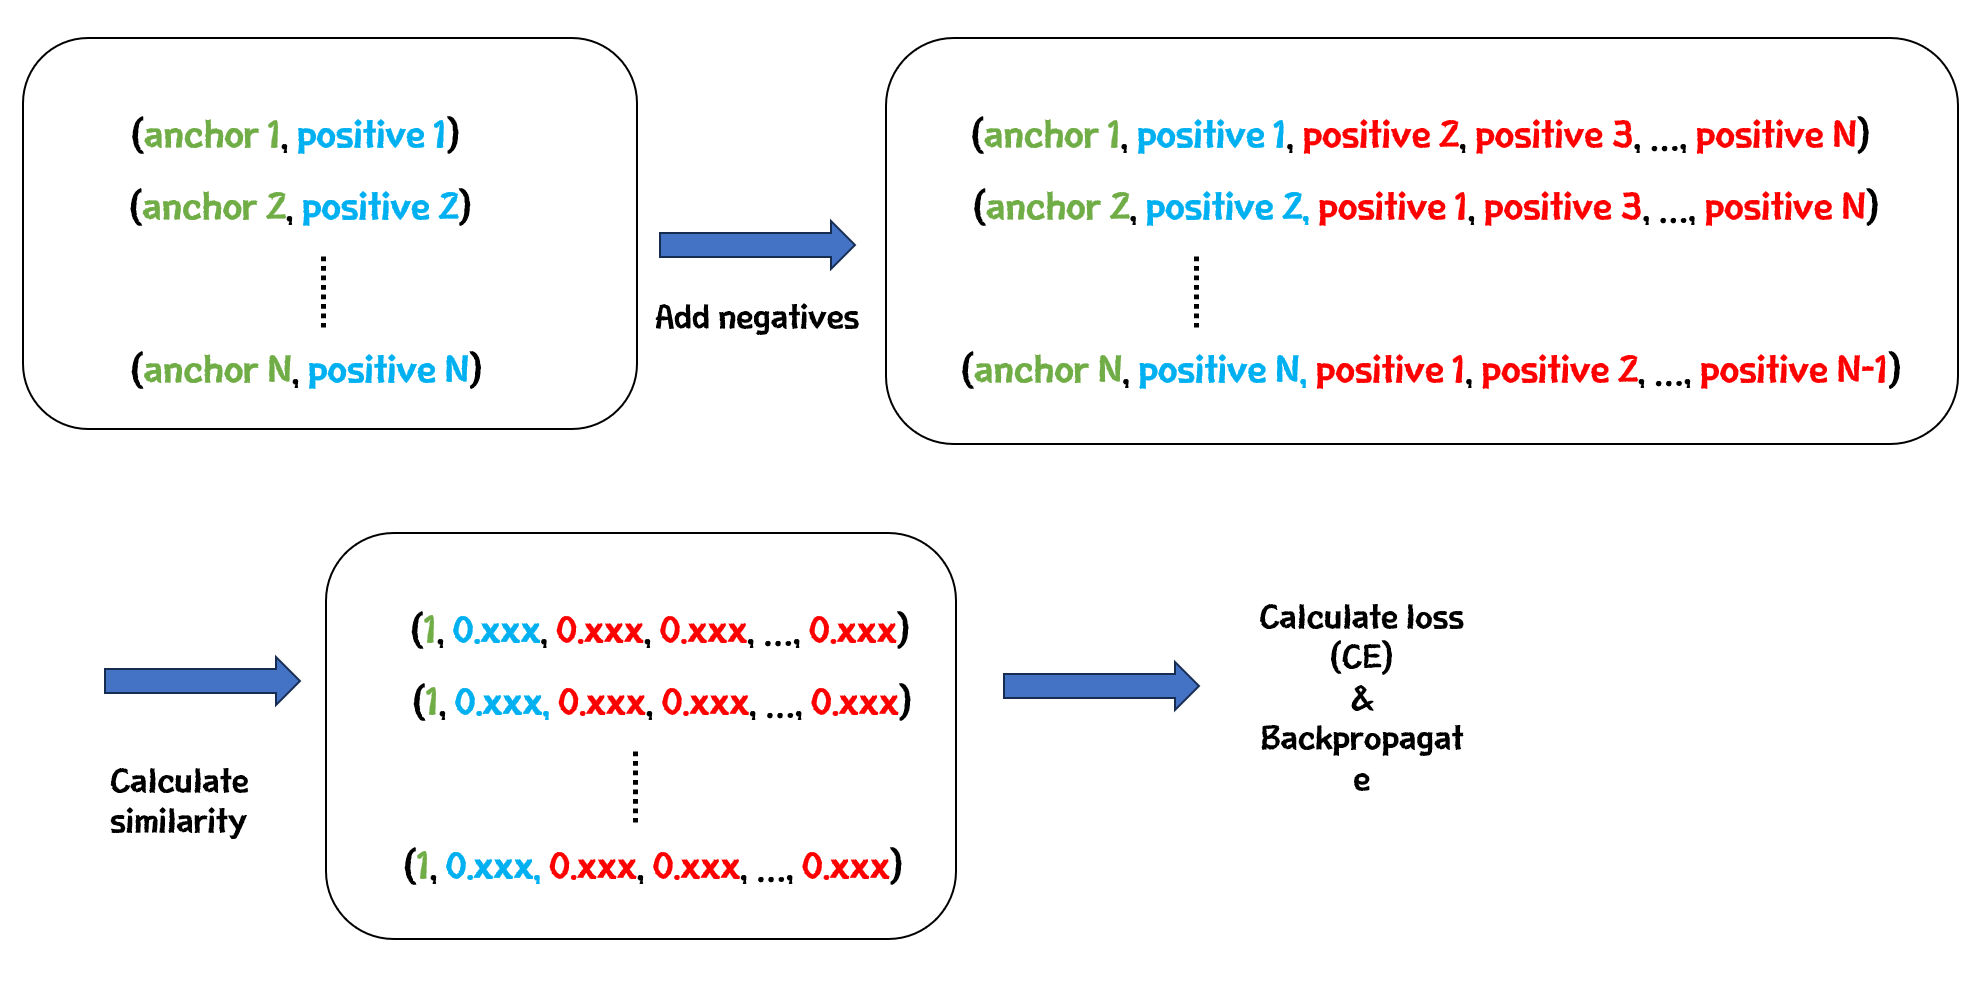

### 🚀 Activity #2-2: MatryoshkaLoss  (thanks to ChatGPT)

- The *MatryoshkaLoss* is a "loss modifier" that works with existing loss functions, such as *MultipleNegativesRankingLoss*, to train a model at various embedding dimensions.

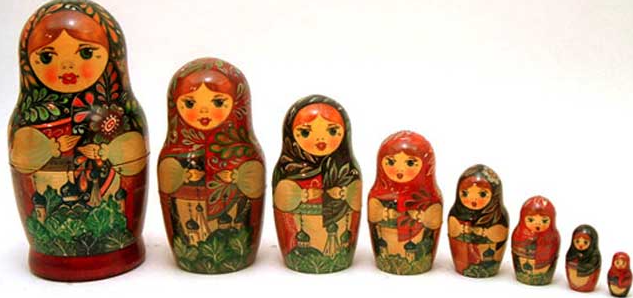

- How does it work? 
    - **Base Loss Function**: *MatryoshkaLoss* is not a loss function on its own but acts as a wrapper around an existing loss function. 
    - **Embedding Dimension**: You provide a list of embedding dimensions (e.g., [768, 512, 256, 128, 64]). The *MatryoshkaLoss* will train the model to perform well at each of these dimensions. 
    - **Embedding Shrinking and Normalization**:  
        - For each reduced demonsion, fet an embedding of the dimension by truncation and normalization.
    - **Loss Calculation at Multiple Dimensions**: The losses for dimention are aggregated to one loss value (weighted sum is possible).

- Why use *MatryoshkaLoss*?
    - **Flexibility in Embedding Size**: It allows the model to generate embeddings of different sizes without retraining
    - **Efficiency**: Smaller embeddings are faster to compute and use less memory. Training the model to perform well with smaller embeddings can be beneficial in low-latency or resource-constrained environments.
    - **Compatibility with Existing Losses**: It works with various existing loss functions.

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [43]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

In [44]:
# 🚀 my own cell
# 🚀 "from sentence_transformers.evaluation import InformationRetrievalEvaluator" 
#       -> Evaluate the performance of a model on an information retrieval

'''
evaluator = InformationRetrievalEvaluator(
    queries = queries,  # A dictionary mapping query IDs to queries.
    corpus = corpus,  # A dictionary mapping document IDs to documents.
    relevant_docs   # A dictionary mapping query IDs to a set of relevant document IDs.
    )
'''

''' 
    Score-Function: cosine
    Accuracy@1 / Accuracy@3 / Accuracy@5 / Accuracy@10 / Precision@1 / Precision@3
    Precision@5 / Precision@10 / Recall@1 / Recall@3 / Recall@5 / Recall@10 / MRR@10
    NDCG@10 / MAP@100 / 
    Score-Function: dot
    Accuracy@1 / Accuracy@3 / Accuracy@5 / Accuracy@10 / Precision@1 / Precision@3
    Precision@5 / Precision@10 / Recall@1 / Recall@3 / Recall@5 / Recall@10 / MRR@10
    NDCG@10 / MAP@100
'''

' \n    Score-Function: cosine\n    Accuracy@1 / Accuracy@3 / Accuracy@5 / Accuracy@10 / Precision@1 / Precision@3\n    Precision@5 / Precision@10 / Recall@1 / Recall@3 / Recall@5 / Recall@10 / MRR@10\n    NDCG@10 / MAP@100 / \n    Score-Function: dot\n    Accuracy@1 / Accuracy@3 / Accuracy@5 / Accuracy@10 / Precision@1 / Precision@3\n    Precision@5 / Precision@10 / Recall@1 / Recall@3 / Recall@5 / Recall@10 / MRR@10\n    NDCG@10 / MAP@100\n'

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [45]:
EPOCHS = 5

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [47]:
# 🚀 My own cell

import torch

if torch.cuda.is_available():
    print(f"CUDA Available")
    num_gpus = torch.cuda.device_count()
    print(f"Number of Available GPUs: {num_gpus}")

CUDA Available
Number of Available GPUs: 1


In [47]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)  # 🚀 Stability purpose. 10% of the total number of steps

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50,
)

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100,Dot Accuracy@1,Dot Accuracy@3,Dot Accuracy@5,Dot Accuracy@10,Dot Precision@1,Dot Precision@3,Dot Precision@5,Dot Precision@10,Dot Recall@1,Dot Recall@3,Dot Recall@5,Dot Recall@10,Dot Ndcg@10,Dot Mrr@10,Dot Map@100
30,No log,No log,0.810000,0.950000,1.000000,1.000000,0.810000,0.316667,0.200000,0.100000,0.810000,0.950000,1.000000,1.000000,0.909384,0.879333,0.879333,0.810000,0.950000,1.000000,1.000000,0.810000,0.316667,0.200000,0.100000,0.810000,0.950000,1.000000,1.000000,0.909384,0.879333,0.879333
50,No log,No log,0.830000,0.950000,0.990000,1.000000,0.830000,0.316667,0.198000,0.100000,0.830000,0.950000,0.990000,1.000000,0.922573,0.896667,0.896667,0.830000,0.950000,0.990000,1.000000,0.830000,0.316667,0.198000,0.100000,0.830000,0.950000,0.990000,1.000000,0.922573,0.896667,0.896667
60,No log,No log,0.850000,0.960000,0.990000,1.000000,0.850000,0.320000,0.198000,0.100000,0.850000,0.960000,0.990000,1.000000,0.931957,0.909167,0.909167,0.850000,0.960000,0.990000,1.000000,0.850000,0.320000,0.198000,0.100000,0.850000,0.960000,0.990000,1.000000,0.931957,0.909167,0.909167
90,No log,No log,0.850000,0.970000,0.990000,0.990000,0.850000,0.323333,0.198000,0.099000,0.850000,0.970000,0.990000,0.990000,0.929521,0.909000,0.909909,0.850000,0.970000,0.990000,0.990000,0.850000,0.323333,0.198000,0.099000,0.850000,0.970000,0.990000,0.990000,0.929521,0.909000,0.909909
100,No log,No log,0.850000,0.970000,0.990000,0.990000,0.850000,0.323333,0.198000,0.099000,0.850000,0.970000,0.990000,0.990000,0.928211,0.907333,0.908167,0.850000,0.970000,0.990000,0.990000,0.850000,0.323333,0.198000,0.099000,0.850000,0.970000,0.990000,0.990000,0.928211,0.907333,0.908167
120,No log,No log,0.860000,0.970000,0.990000,0.990000,0.860000,0.323333,0.198000,0.099000,0.860000,0.970000,0.990000,0.990000,0.931902,0.912333,0.913167,0.860000,0.970000,0.990000,0.990000,0.860000,0.323333,0.198000,0.099000,0.860000,0.970000,0.990000,0.990000,0.931902,0.912333,0.913167
150,No log,No log,0.860000,0.970000,0.990000,0.990000,0.860000,0.323333,0.198000,0.099000,0.860000,0.970000,0.990000,0.990000,0.931902,0.912333,0.913167,0.860000,0.970000,0.990000,0.990000,0.860000,0.323333,0.198000,0.099000,0.860000,0.970000,0.990000,0.990000,0.931902,0.912333,0.913167


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [48]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [49]:
from tqdm.notebook import tqdm


# 🚀 I swaped out the name of the function for 'evaluate_IR_for_embedding_model'
def evaluate_IR_for_embedding_model(
    dataset,  # For IR (information retrieval) tasks, dtaset consists of corpus, questions, and relevant contexts.
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-m`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [50]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_IR_for_embedding_model(test_dataset, te3_openai)

  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
te3_results_df = pd.DataFrame(te3_results)
te3_results_df

,id,question,expected_id,is_hit
0,7d7752a3-f94f-4e89-a9c6-bf0d96aab3ba,What principles should national competent auth...,7b23e7b5-5bc0-499f-b6f1-c86391dfe584,True
1,27ee31eb-ce40-4a43-8800-2c6feb72b6c1,What are the expectations for the members of n...,7b23e7b5-5bc0-499f-b6f1-c86391dfe584,True
2,d1739600-0628-4afe-8778-3dbd714e582f,What is the purpose of a post-market monitorin...,ba50e489-e530-4d87-9d70-d6e285d8b064,True
3,74e9e8b6-c23c-403d-81d2-51b786ecbe9f,What types of data should post-market monitori...,ba50e489-e530-4d87-9d70-d6e285d8b064,True
4,64ecafc7-b221-47db-addf-8714c09cf8c9,What types of incidents must providers report ...,b5391d2b-db39-42cb-b4b5-425c1b9f7d53,True
...,...,...,...,...
95,d8628e29-b81d-4b42-8146-32f9234bfe6d,By what date should codes of practice be ready...,f30eee02-6569-4dc9-8799-314bb84978e1,True
96,2b48e802-e809-4cff-8acf-02b639cc3ee3,When do the provisions on penalties apply from?,791a9379-c88c-4258-95be-7d73efd0a4df,True
97,b680d313-977c-40f7-b5dd-ee094330f99b,What date is specified for the application of ...,791a9379-c88c-4258-95be-7d73efd0a4df,True
98,781a54af-cbe7-43dc-86f2-1de35908ca5d,What is the purpose of the Regulation mentione...,92df5ae0-6c9e-47c1-8378-0f87a9c3f981,False


In [52]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

0.98

### `Snowflake/snowflake-arctic-embed-m` (base)

#### 🚀 langchain_huggingface

- langchain_huggingface.ChatHuggingFace [here](https://api.python.langchain.com/en/latest/_modules/langchain_huggingface/chat_models/huggingface.html#ChatHuggingFace)
- langchain_huggingface.HuggingFaceEmbeddings [here](https://api.python.langchain.com/en/latest/_modules/langchain_huggingface/embeddings/huggingface.html#HuggingFaceEmbeddings)

In [53]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-m")
arctic_embed_m_results = evaluate_IR_for_embedding_model(test_dataset, huggingface_embeddings)

  0%|          | 0/100 [00:00<?, ?it/s]

In [54]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)
arctic_embed_m_results_df

,id,question,expected_id,is_hit
0,7d7752a3-f94f-4e89-a9c6-bf0d96aab3ba,What principles should national competent auth...,7b23e7b5-5bc0-499f-b6f1-c86391dfe584,True
1,27ee31eb-ce40-4a43-8800-2c6feb72b6c1,What are the expectations for the members of n...,7b23e7b5-5bc0-499f-b6f1-c86391dfe584,True
2,d1739600-0628-4afe-8778-3dbd714e582f,What is the purpose of a post-market monitorin...,ba50e489-e530-4d87-9d70-d6e285d8b064,True
3,74e9e8b6-c23c-403d-81d2-51b786ecbe9f,What types of data should post-market monitori...,ba50e489-e530-4d87-9d70-d6e285d8b064,False
4,64ecafc7-b221-47db-addf-8714c09cf8c9,What types of incidents must providers report ...,b5391d2b-db39-42cb-b4b5-425c1b9f7d53,True
...,...,...,...,...
95,d8628e29-b81d-4b42-8146-32f9234bfe6d,By what date should codes of practice be ready...,f30eee02-6569-4dc9-8799-314bb84978e1,False
96,2b48e802-e809-4cff-8acf-02b639cc3ee3,When do the provisions on penalties apply from?,791a9379-c88c-4258-95be-7d73efd0a4df,True
97,b680d313-977c-40f7-b5dd-ee094330f99b,What date is specified for the application of ...,791a9379-c88c-4258-95be-7d73efd0a4df,True
98,781a54af-cbe7-43dc-86f2-1de35908ca5d,What is the purpose of the Regulation mentione...,92df5ae0-6c9e-47c1-8378-0f87a9c3f981,False


In [55]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

0.58

### `Snowflake/snowflake-arctic-embed-m` (fine-tuned)

In [56]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic")
finetune_results = evaluate_IR_for_embedding_model(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
finetune_results_df = pd.DataFrame(finetune_results)

In [58]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

0.99

# 🤝 Breakout Room #2

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [59]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,  # from 750 to 600
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(training_documents_loaded.load())
len(training_documents)

1299

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [60]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})
base_retriever = base_retriever.with_config({"run_name": "R: FAISS_Retriever_with_BaseEmbedding"})

#### A - Augmented

In [61]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)
rag_prompt_template = rag_prompt_template.with_config({"run_name": "A: ChatPrompt"})

#### G - Generation

In [62]:
rag_llm =  ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)
rag_llm = rag_llm.with_config({"run_name": "G: LLM"})

#### RAG - LCEL RAG Pipeline

In [63]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

base_rag_chain = base_rag_chain.with_config({"run_name": "RAG_with_BaseEmbedding"})

In [64]:
base_rag_chain.invoke({"question" : "Why does the EU want to regulate AI?"})["response"]

'The EU wants to regulate AI to promote a human-centric approach to AI, ensure the development of secure, trustworthy, and ethical AI, protect ethical principles, and facilitate the protection of natural persons, undertakings, democracy, the rule of law, and environmental protection. Additionally, the regulation aims to boost innovation and employment, positioning the Union as a leader in the uptake of trustworthy AI.'

In [65]:
base_rag_chain.invoke({"question" : "What are the codes of practice?"})["response"]

'I do not know.'

In [66]:
base_rag_chain.invoke({"question" : "How many parameters is too many parameters?"})["response"]

'The context suggests that models with at least a billion parameters are considered to display significant generality and competence in performing a wide range of tasks. Therefore, it can be inferred that having a billion parameters is a threshold for being considered a model with "too many" parameters in this context.'

In [67]:
base_rag_chain.invoke({"question" : "What is an emotion recognition system and why is it important?"})["response"]

'An emotion recognition system is a type of artificial intelligence (AI) technology designed to identify and interpret human emotions based on various inputs, such as facial expressions, voice tone, body language, or biometric data. These systems analyze patterns in the data to infer the emotional state of an individual.\n\nThe importance of emotion recognition systems lies in their potential applications across various fields, including mental health, customer service, security, and human-computer interaction. They can enhance user experiences, improve communication, and provide insights into emotional well-being. However, there are significant concerns regarding their reliability, specificity, and potential for discriminatory outcomes, particularly given the variability of emotional expression across different cultures and individuals.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [68]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})
finetune_retriever = finetune_retriever.with_config({"run_name": "R: FAISS_Retriever_with_FinetunedEmbedding"})

In [69]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

finetune_rag_chain = finetune_rag_chain.with_config({"run_name": "RAG_with_FinetunedEmbedding"})

In [70]:
finetune_rag_chain.invoke({"question" : "Why does the EU want to regulate AI?"})["response"]

'The EU wants to regulate AI to improve the functioning of the internal market, promote the uptake of human-centric and trustworthy artificial intelligence, ensure a high level of protection of health, safety, and fundamental rights, protect against the harmful effects of AI systems, and support innovation.'

In [71]:
finetune_rag_chain.invoke({"question" : "What are the codes of practice?"})["response"]

'Codes of practice are guidelines developed to ensure compliance with obligations for providers of general-purpose AI models, particularly those that present systemic risks. They aim to establish a risk taxonomy for systemic risks at the Union level, including their sources, and focus on specific risk assessment and mitigation measures. The AI Office is responsible for encouraging and facilitating the creation, review, and adaptation of these codes, which should reflect the state of the art and consider diverse perspectives. The codes of practice are expected to be ready by May 2, 2025, and can help providers demonstrate compliance with regulatory obligations.'

In [72]:
finetune_rag_chain.invoke({"question" : "How many parameters is too many parameters?"})["response"]

'The context suggests that models with at least a billion parameters are considered to display significant generality and to competently perform a wide range of distinctive tasks. Therefore, it can be inferred that having a billion parameters is a threshold for being considered a model with "significant generality." However, the context does not specify a limit beyond which the number of parameters would be considered "too many." Thus, I do not know the answer to how many parameters is too many parameters.'

In [73]:
finetune_rag_chain.invoke({"question" : "What is an emotion recognition system and why is it important?"})["response"]

'An emotion recognition system is defined as an AI system that identifies or infers the emotions or intentions of natural persons based on their biometric data. This includes recognizing emotions such as happiness, sadness, anger, surprise, disgust, embarrassment, excitement, shame, contempt, satisfaction, and amusement. \n\nThe importance of emotion recognition systems lies in their potential applications across various fields, such as enhancing user experience in technology, improving mental health assessments, and providing insights in customer service. However, there are significant concerns regarding their reliability, cultural variability in emotional expression, and the potential for discriminatory outcomes, which raises ethical considerations about their use.'

##### ❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?


##### 🚀 Answer to Question #2:

- Q1) Why does the EU want to regulate AI?
    - Base: The EU wants to regulate AI to promote a human-centric approach to AI, ensure the development of secure, trustworthy, and ethical AI, protect ethical principles, and facilitate the protection of natural persons, undertakings, democracy, the rule of law, and environmental protection. Additionally, the regulation aims to boost innovation and employment, positioning the Union as a leader in the uptake of trustworthy AI.
    
    - Finetuned:The EU wants to regulate AI to improve the functioning of the internal market, promote the uptake of human-centric and trustworthy artificial intelligence, ensure a high level of protection of health, safety, and fundamental rights, protect against the harmful effects of AI systems, and support innovation. 

- Q2) What are the codes of practice?
    - Base: I do not know.

    - Finetuned: Codes of practice are guidelines developed to ensure compliance with obligations for providers of general-purpose AI models, particularly those that present systemic risks. They aim to establish a risk taxonomy for systemic risks at the Union level, including their sources, and focus on specific risk assessment and mitigation measures. The AI Office is responsible for encouraging and facilitating the creation, review, and adaptation of these codes, which should reflect the state of the art and consider diverse perspectives. The codes of practice are expected to be ready by May 2, 2025, and can help providers demonstrate compliance with regulatory obligations.

- Q3) How many parameters is too many parameters?
    - Base: The context suggests that models with at least a billion parameters are considered to display significant generality and competence in performing a wide range of tasks. Therefore, it can be inferred that having a billion parameters is a threshold for being considered a model with "too many" parameters in this context.

    - Finetuned: The context suggests that models with at least a billion parameters are considered to display significant generality and to competently perform a wide range of distinctive tasks. Therefore, it can be inferred that having a billion parameters is a threshold for being considered a model with "significant generality." However, the context does not specify a limit beyond which the number of parameters would be considered "too many." Thus, I do not know the answer to how many parameters is too many parameters.

- Q4) What is an emotion recognition system and why is it important?
    - Base: An emotion recognition system is a type of artificial intelligence (AI) technology designed to identify and interpret human emotions based on various inputs, such as facial expressions, voice tone, body language, or biometric data. These systems analyze patterns in the data to infer the emotional state of an individual.\n\nThe importance of emotion recognition systems lies in their potential applications across various fields, including mental health, customer service, security, and human-computer interaction. They can enhance user experiences, improve communication, and provide insights into emotional well-being. However, there are significant concerns regarding their reliability, specificity, and potential for discriminatory outcomes, particularly given the variability of emotional expression across different cultures and individuals.
    
    - Finetuned:An emotion recognition system is defined as an AI system that identifies or infers the emotions or intentions of natural persons based on their biometric data. This includes recognizing emotions such as happiness, sadness, anger, surprise, disgust, embarrassment, excitement, shame, contempt, satisfaction, and amusement. \n\nThe importance of emotion recognition systems lies in their potential applications across various fields, such as enhancing user experience in technology, improving mental health assessments, and providing insights in customer service. However, there are significant concerns regarding their reliability, cultural variability in emotional expression, and the potential for discriminatory outcomes, which raises ethical considerations about their use.


Thoughts
- Out of the four qestions, our finetuned model could answer all of them while the baseline failed for Question 2.
- It might be a sign that the finetuned one is more performant than the baseline since our RAG pipeline is programmed to repond only there are relevant contexts provide. 
- Of course it is necessary to do more holistic evaluation to prove the claim.

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

In [102]:
# !pip install -qU ragas

### RAGAS Synthetic Testset Generation

First things first, we need to generate some data to test our model on.

Let's use our test data that we created before as a base!

In [55]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

In [50]:
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

In [54]:
# 😢 The code below rasies an error. I will fix it later.


# testset = generator.generate_with_langchain_docs(
#     documents=test_split_documents, 
#     test_size=20, 
#     distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25},
#     )



In [ ]:
# 😢 Could not run this

# testset.to_pandas().head()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How does the right to obtain an explanation ap...,[(171) Affected persons should have the right ...,The right to obtain an explanation applies to ...,simple,"[{'source': 'eu_ai_act.html', 'id': '610502a8-...",True
1,What is the objective of promoting the uptake ...,"[(176) Since the objective of this Regulation,...",The objective of promoting the uptake of human...,simple,"[{'source': 'eu_ai_act.html', 'id': 'ab0da426-...",True
2,What is the role of the European Parliament in...,[(174) Given the rapid technological developme...,The Commission should evaluate and review this...,simple,"[{'source': 'eu_ai_act.html', 'id': '25c8c027-...",True
3,How can the development of AI systems other th...,[(165) The development of AI systems other tha...,The development of AI systems other than high-...,simple,"[{'source': 'eu_ai_act.html', 'id': 'bad7a72a-...",True
4,What is included in the scope of Union financi...,[undertakings and insurance holding companies ...,Undertakings and insurance holding companies u...,simple,"[{'source': 'eu_ai_act.html', 'id': '9c66e276-...",True


### Generating Answer Datasets

For each of our pipelines, let's generate answers to these questions!

Once we have our: Questions, Answers, Contexts, Ground Truths we can move on to evaluating our datasets!

In [ ]:
# 😢 Could not run this

# from datasets import Dataset

# def generate_answers(chain, testset):
#   answers = []
#   contexts = []
#   questions = testset.to_pandas()["question"].values.tolist()
#   ground_truths = testset.to_pandas()["ground_truth"].values.tolist()

#   for question in tqdm(questions):
#     answer = chain.invoke({"question" : question})
#     answers.append(answer["response"])
#     contexts.append([context.page_content for context in answer["context"]])

#   return Dataset.from_dict({
#       "question" : questions,
#       "answer" : answers,
#       "contexts" : contexts,
#       "ground_truth" : ground_truths
#   })

In [ ]:
# 😢 Could not run this
# base_dataset = generate_answers(base_rag_chain, testset)

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


In [ ]:
# 😢 Could not run this
# finetune_dataset = generate_answers(finetune_rag_chain, testset)

100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


### Evaluating Using the Test Set

Now that we have a test set - it's time to evaluate our pipelines with it!

In [112]:
from ragas.metrics import (
    context_recall,
    context_precision,
)

In [ ]:
# 😢 Could not run this

# from ragas import evaluate

# result = evaluate(
#     base_dataset,
#     metrics=[
#         context_precision,
#         context_recall,
#     ],
# )

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[26]: TimeoutError()


In [ ]:
# 😢 Could not run this

# result

{'context_precision': 0.5649, 'context_recall': 0.6083}

In [ ]:
# 😢 Could not run this
# result.to_pandas().head()

,question,contexts,answer,ground_truth,context_precision,context_recall
0,How does the right to obtain an explanation ap...,[right to obtain an explanation should not app...,The right to obtain an explanation does not ap...,The right to obtain an explanation applies to ...,1.000000,0.333333
1,What is the objective of promoting the uptake ...,[of protection or the need for compliance with...,I do not know.,The objective of promoting the uptake of human...,0.000000,0.000000
2,What is the role of the European Parliament in...,[of the high-risk AI system with the requireme...,I do not know.,The Commission should evaluate and review this...,0.250000,0.500000
3,How can the development of AI systems other th...,[of protection or the need for compliance with...,The development of AI systems other than high-...,The development of AI systems other than high-...,0.166667,0.666667
4,What is included in the scope of Union financi...,[(45) Practices that are prohibited by Union l...,I do not know.,Undertakings and insurance holding companies u...,0.250000,1.000000


In [ ]:
# 😢 Could not run this

# result = evaluate(
#     finetune_dataset,
#     metrics=[
#         context_precision,
#         context_recall,
#     ],
# )

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# 😢 Could not run this
# result

{'context_precision': 0.9174, 'context_recall': 0.8792}

In [ ]:
# 😢 Could not run this
# result.to_pandas().head()

,question,contexts,answer,ground_truth,context_precision,context_recall
0,How does the right to obtain an explanation ap...,[right to obtain an explanation should not app...,The right to obtain an explanation applies to ...,The right to obtain an explanation applies to ...,1.000000,1.000000
1,What is the objective of promoting the uptake ...,[(6) Given the major impact that AI can have o...,The objective of promoting the uptake of human...,The objective of promoting the uptake of human...,1.000000,0.000000
2,What is the role of the European Parliament in...,[Official Journal of the European Union EN L s...,The European Parliament plays a role in evalua...,The Commission should evaluate and review this...,1.000000,1.000000
3,How can the development of AI systems other th...,[(165) The development of AI systems other tha...,The development of AI systems other than high-...,The development of AI systems other than high-...,0.810000,0.666667
4,What is included in the scope of Union financi...,[(158) Union financial services law includes i...,Union financial services law includes internal...,Undertakings and insurance holding companies u...,0.633333,1.000000


#### 🏗️ Activity #3:

Discuss changes that you'd make to this pipeline based on the performance improvements that you see with RAGAS and the fine-tuning.

Come up with 3 changes, and then we'll discuss these options as a group!

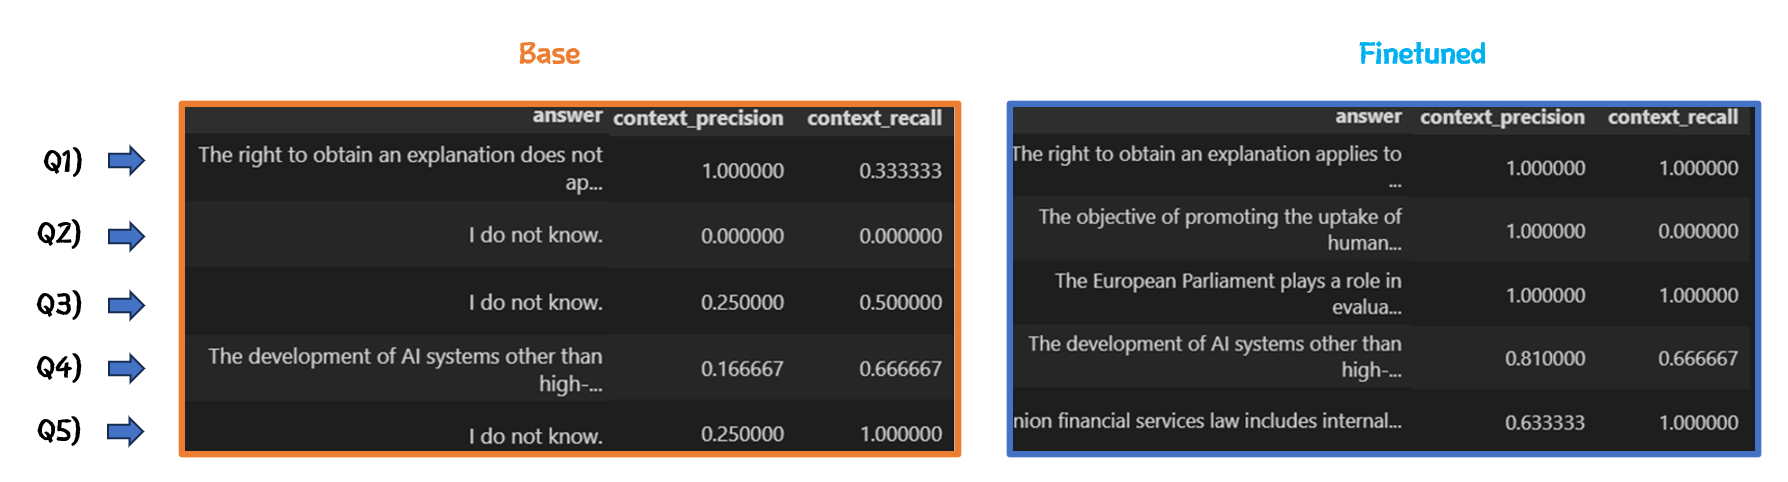


1. Low *context_precision* often results in the RAG pipeline not able to respond. In many cases, the base embedding model failed to retrieve relevant docs and it caused low *context_precision*. On the other hand, the finetuned embedding model noticably improved *context_precision* and allowed the RAG pipeline to respond based on the retrieved contexts.

2. Finetuned embedding model also seems to improve *context_recall* which will help the RAG pipeline provide more helpful and coherent answers.

3. Not provided other metrics like anser_relevancy or Faithfullness, we can easily infer that they will also be improved considering *context_precision* and *context_recall*. 